# Preparation and evaluation of manual annotation

This notebook is a part of the project to create a dataset for manual annotation. This dataset will be the same as the test set used for our model. The goal is to evaluate the quality of the model compared to a human annotator and to understand the errors made by the model. 

## Step 1: Create full dataset consisting of human generated text and AI generated text

In [16]:
import pandas as pd

path1 = "data/reddit_posts/ai_generated/cleaned_generated_texts_title_based.csv"
path2 = "data/reddit_posts/ai_generated/cleaned_rephrased_texts.csv"

# Read the CSV files into DataFrames
df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)

# Select specific columns from df1 and df2
selected_columns_df1 = df1[['Combined Text', 'Rewritten Text']]

df2.rename(columns={'Rewritten Text': 'Generated Text'}, inplace=True)
selected_columns_df2 = df2[['Generated Text']]

# Combine the selected columns into a new DataFrame
new_df = pd.concat([selected_columns_df1, selected_columns_df2], axis=1)

In [123]:
new_df.to_csv('combined_file_final.csv', index=False)

In [ ]:
new_df.head()

## Step 2: Create test set for manual annotation

In [126]:
from sklearn.model_selection import train_test_split

In [ ]:
def load_data():
    data = pd.read_csv("combined_file_final.csv", sep=";")
    human_df = data[["Combined Text"]]
    human_df["label"] = 0
    ai_df = data[["Rewritten Text"]]
    ai_df["label"] = 1
    ai_df2 = data[["Generated Text"]]
    ai_df2["label"] = 1
    human_df = human_df.rename(columns={"Combined Text": "Text"})
    ai_df = ai_df.rename(columns={"Rewritten Text": "Text"})
    ai_df2 = ai_df2.rename(columns={"Generated Text": "Text"})
    data = pd.concat([human_df, ai_df, ai_df2], ignore_index=True)
    return data

data = load_data()
data.head()

In [ ]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
train_texts, test_texts, train_labels, test_labels = train_test_split(data["Text"], data["label"], test_size=0.2, random_state=42, stratify=data["label"])    
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42, stratify=train_labels)
train_texts

In [98]:
# Save the test texts and labels to separate CSV files
test_texts.to_csv('test_texts_manuel_annotation.csv', index=False, header=True)
test_labels.to_csv('test_labels_manuel_annotation.csv', index=False, header=True)


In [ ]:
print(train_texts.shape)
print(test_texts.shape)

## Step 3: Evaluate manual annotation

In [55]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
data_path = "data/evaluation/test_texts_manually_annotated.csv"

df = pd.read_csv(data_path, delimiter=';')

# Remove rows where 'Label' is not given
df = df.dropna(subset=['Label'])
print(df.shape)

(599, 3)


In [45]:
clean_generated_texts_path = "data/reddit_posts/ai_generated/cleaned_generated_texts_title_based.csv"
clean_rephrased_texts_path = "data/reddit_posts/ai_generated/cleaned_rephrased_texts.csv"

rephrased_texts = pd.read_csv(clean_rephrased_texts_path)
generated_texts = pd.read_csv(clean_generated_texts_path)

# Add the 'Source' column
df['Source'] = df['Text'].apply(lambda x: 'rephrased' if x in rephrased_texts['Rewritten Text'].values else 'generated' if x in generated_texts['Rewritten Text'].values else 'human')

# Count the number of rows by each source
source_counts = df['Source'].value_counts()
print("Counts by source:")
print(source_counts)

Counts by source:
Source
human        212
rephrased    194
generated    193
Name: count, dtype: int64


### Overall evaluation

F1 Score: 0.5574223723350155
Accuracy: 0.5475792988313857
Confusion Matrix:
[[117  95]
 [176 211]]


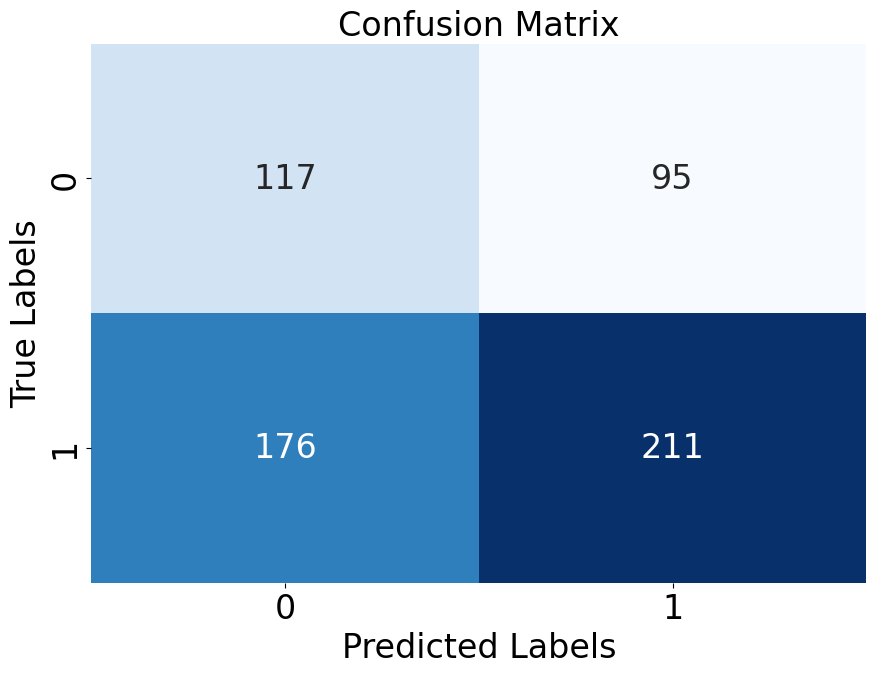

In [46]:
# Compute F1 score and confusion matrix
y_true = df['True label']
y_pred = df['Label']

f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred)

f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix without the legend and with larger numbers and text
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 24})
plt.xlabel('Predicted Labels', fontsize=24)
plt.ylabel('True Labels', fontsize=24)
plt.title('Confusion Matrix', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

### Evaluation by source

In [48]:
# Compute F1 score separated by source
sources = df['Source'].unique()
for source in sources:
    source_df = df[df['Source'] == source]
    y_true_source = source_df['True label']
    y_pred_source = source_df['Label']
    if source == 'human':
        y_true_source = 1 - y_true_source
        y_pred_source = 1 - y_pred_source
    f1_source = f1_score(y_true_source, y_pred_source)
    accuracy_source = accuracy_score(y_true_source, y_pred_source)
    print(f"F1 Score for {source}: {f1_source}")
    print(f"Accuracy for {source}: {accuracy_source}")

F1 Score for rephrased: 0.624113475177305
Accuracy for rephrased: 0.4536082474226804
F1 Score for human: 0.7112462006079028
Accuracy for human: 0.5518867924528302
F1 Score for generated: 0.7784810126582279
Accuracy for generated: 0.6373056994818653


## Model evaluation

### Baseline

In [49]:
import torch

In [59]:
# Read the CSV file
df = pd.read_csv('data/evaluation/results_baseline.csv')

# Apply the torch.sigmoid function to the 'predicted' column
df['predicted'] = torch.sigmoid(torch.tensor(df['predicted'].values)).numpy()

# Convert the 'predicted' values to 1 if they are greater than 0.5, otherwise 0
df['predicted'] = (df['predicted'] > 0.5).astype(int)

In [60]:
# Compute overall F1 score and accuracy
overall_f1 = f1_score(df['label'], df['predicted'])
overall_accuracy = accuracy_score(df['label'], df['predicted'])

print('Overall Metrics:')
print(f'F1 Score: {overall_f1}')
print(f'Accuracy: {overall_accuracy}')
print('---')

# Define a function to compute F1 score and accuracy for a given source type
def compute_metrics(df, source_type):
    source_df = df[df['written'] == source_type]
        
    y_true = source_df['label'].astype(int)
    y_pred = source_df['predicted']

    # Invert if source human
    if source_type == 0:
        y_true = 1 - y_true
        y_pred = 1 - y_pred

    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return f1, accuracy, recall

# Compute metrics for each source type
for source_type, source_name in zip([0, 1, 2], ['human generated', 'rephrased', 'generated']):
    f1, accuracy, reacll = compute_metrics(df, source_type)
    print(f'Source: {source_name}')
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {reacll}')
    print('---')

Overall Metrics:
F1 Score: 0.849967804249839
Accuracy: 0.8128514056224899
---
Source: human generated
F1 Score: 0.9178617992177314
Accuracy: 0.8481927710843373
Recall: 0.8481927710843373
---
Source: rephrased
F1 Score: 0.9790897908979089
Accuracy: 0.9590361445783132
Recall: 0.9590361445783132
---
Source: generated
F1 Score: 0.7740029542097489
Accuracy: 0.6313253012048192
Recall: 0.6313253012048192
---


### Model with POS

In [53]:
# Read the CSV file
df = pd.read_csv('data/evaluation/results_pos.csv')

# Apply the torch.sigmoid function to the 'predicted' column
df['predicted'] = torch.sigmoid(torch.tensor(df['predicted'].values)).numpy()

# Convert the 'predicted' values to 1 if they are greater than 0.5, otherwise 0
df['predicted'] = (df['predicted'] > 0.5).astype(int)

In [57]:
# Compute overall F1 score and accuracy
overall_f1 = f1_score(df['label'], df['predicted'])
overall_accuracy = accuracy_score(df['label'], df['predicted'])

print('Overall Metrics:')
print(f'F1 Score: {overall_f1}')
print(f'Accuracy: {overall_accuracy}')
print('---')

# Define a function to compute F1 score and accuracy for a given source type
def compute_metrics(df, source_type):
    source_df = df[df['written'] == source_type]
        
    y_true = source_df['label'].astype(int)
    y_pred = source_df['predicted']

    # Invert if source human
    if source_type == 0:
        y_true = 1 - y_true
        y_pred = 1 - y_pred

    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return f1, accuracy, recall

# Compute metrics for each source type
for source_type, source_name in zip([0, 1, 2], ['human generated', 'rephrased', 'generated']):
    f1, accuracy, recall = compute_metrics(df, source_type)
    print(f'Source: {source_name}')
    print(f'F1 Score: {f1}')
    print(f'Accuracy: {accuracy}')
    print(f"Recall: {recall}")
    print('---')

Overall Metrics:
F1 Score: 0.8634146341463415
Accuracy: 0.8200803212851405
---
Source: human generated
F1 Score: 0.8598901098901099
Accuracy: 0.7542168674698795
Recall: 0.7542168674698795
---
Source: rephrased
F1 Score: 0.9902676399026764
Accuracy: 0.980722891566265
Recall: 0.980722891566265
---
Source: generated
F1 Score: 0.840782122905028
Accuracy: 0.7253012048192771
Recall: 0.7253012048192771
---
